In [1]:
#Bibliotecas
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
from pandas.core.reshape.merge import merge
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),1)

def media_agregada(x):    
    return round(((x.sum())/12.0),0)

In [3]:
#Seleção do Periodo de análise

inicio = '2017-09-01'

fim = '2022-03-01'

Periodo = [inicio, fim]

In [4]:
#Caminho da pasta com as bases de dados 
path = r'D:\TCC\Microdados_SUS\diops\receita_contraprestacoes_despesas'

#Leitura das Bases de Dados
text_files = [f for f in os.listdir(path) if f.endswith(".csv")] #Lista com todos os nomes dos arquivos csv contidos na pasta

diops_microdados = pd.concat([pd.read_csv(path+'\\'+f, sep=';', decimal= ',', encoding='utf-8') for f in text_files]) #Leitura e concatenação de todas as bases

diops_microdados

,Unnamed: 0,CMPT,ANO,MES,MODALIDADE,OPERADORA,RECEITA,OUTRAS_REC,DESP_AST,DESP_ADM,DESPESAS_C,OUTRAS_DES,DATA_CARGA,REF
0,1,201410,2014,10,28,27,46314157.00,110407,43010083.00,6937173,3325671,2621642,20220624 0,1
1,2,201410,2014,10,28,477,561064441.00,385210,478476506.00,57116224,39119331,7243256,20220624 0,0
2,3,201410,2014,10,28,515,798613880.00,0,879916361.00,52747067,73149693,86429357,20220624 0,0
3,4,201410,2014,10,28,582,1053251730.00,0,796825208.00,127508666,82400006,16457911,20220624 0,0
4,5,201410,2014,10,28,701,1901380438.00,1919770,1634083139.00,157131586,126815933,20605187,20220624 0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,1078,202110,2021,10,55,423041,0.00,0,0.00,35315,0,0,20220624 0,1
1078,1079,202110,2021,10,26,423050,0.00,0,0.00,15663,0,0,20220624 0,1
1079,1080,202110,2021,10,55,423076,0.00,0,0.00,1,0,0,20220624 0,1
1080,1081,202110,2021,10,26,423092,0.00,0,0.00,2384,0,0,20220624 0,1


In [5]:
#Caminho da pasta com as bases de dados 
path_benef = r'D:\TCC\Microdados_SUS\Beneficiarios\Operadoras'

#Leitura das Bases de Dados
text_files_benef = [f for f in os.listdir(path_benef) if f.endswith(".csv")] #Lista com todos os nomes dos arquivos csv contidos na pasta

sib_microdados = pd.concat([pd.read_csv(path_benef+'\\'+f, sep=';', decimal= ',', encoding='utf-8') for f in text_files_benef]) #Leitura e concatenação de todas as bases

sib_microdados

,Unnamed: 0,ID_CMPT,CD_OPERADO,MODALIDADE,PORTE,LG_CAPITAL,CD_RM_O,SG_UF_O,SG_UF,LG_CAPITA0,CD_CAPITAL,CD_RM,NR_BENEF_O,NR_BENEF_M,NR_BENEF_T,OPS_ATV,OPS_BEN,CD_CONTR
0,1,201603,347736,22,5,0,0,MG,RJ,1,330455,3301,0,2,2,1,1,1
1,2,201603,347736,22,5,0,0,MG,RJ,1,330455,3301,0,1,1,1,1,3
2,3,201603,347736,22,5,0,0,MG,RJ,0,0,0,0,4,4,1,1,2
3,4,201603,347736,22,5,0,0,MG,BA,0,0,0,0,2,2,1,1,1
4,5,201603,347736,22,5,0,0,MG,RS,0,0,4301,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48176,48177,202112,359289,22,8,0,3103,MG,SC,0,0,4201,0,24,24,1,1,3
48177,48178,202112,359289,22,8,0,3103,MG,GO,1,520870,5201,0,430,430,1,1,2
48178,48179,202112,359289,22,8,0,3103,MG,BA,0,0,2901,0,11,11,1,1,3
48179,48180,202112,359289,22,8,0,3103,MG,ES,0,0,3201,0,5,5,1,1,1


In [6]:
diops_microdados = diops_microdados[(diops_microdados['MODALIDADE']!= 23) & (diops_microdados['MODALIDADE']!= 26)]

diops_microdados.drop(diops_microdados[['Unnamed: 0','MES','DATA_CARGA','REF']], axis='columns', inplace=True)

diops_microdados

,CMPT,ANO,MODALIDADE,OPERADORA,RECEITA,OUTRAS_REC,DESP_AST,DESP_ADM,DESPESAS_C,OUTRAS_DES
0,201410,2014,28,27,46314157.00,110407,43010083.00,6937173,3325671,2621642
1,201410,2014,28,477,561064441.00,385210,478476506.00,57116224,39119331,7243256
2,201410,2014,28,515,798613880.00,0,879916361.00,52747067,73149693,86429357
3,201410,2014,28,582,1053251730.00,0,796825208.00,127508666,82400006,16457911
4,201410,2014,28,701,1901380438.00,1919770,1634083139.00,157131586,126815933,20605187
...,...,...,...,...,...,...,...,...,...,...
1075,202110,2021,55,422991,0.00,0,0.00,21888,0,0
1076,202110,2021,55,423017,0.00,0,0.00,0,0,0
1077,202110,2021,55,423041,0.00,0,0.00,35315,0,0
1079,202110,2021,55,423076,0.00,0,0.00,1,0,0


In [7]:
sib_microdados = sib_microdados[(sib_microdados['MODALIDADE']!= 23) & (sib_microdados['MODALIDADE']!= 26)]

sib_microdados.drop(sib_microdados[['Unnamed: 0','NR_BENEF_O']], axis='columns', inplace=True)

sib_microdados

,ID_CMPT,CD_OPERADO,MODALIDADE,PORTE,LG_CAPITAL,CD_RM_O,SG_UF_O,SG_UF,LG_CAPITA0,CD_CAPITAL,CD_RM,NR_BENEF_M,NR_BENEF_T,OPS_ATV,OPS_BEN,CD_CONTR
0,201603,347736,22,5,0,0,MG,RJ,1,330455,3301,2,2,1,1,1
1,201603,347736,22,5,0,0,MG,RJ,1,330455,3301,1,1,1,1,3
2,201603,347736,22,5,0,0,MG,RJ,0,0,0,4,4,1,1,2
3,201603,347736,22,5,0,0,MG,BA,0,0,0,2,2,1,1,1
4,201603,347736,22,5,0,0,MG,RS,0,0,4301,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48176,202112,359289,22,8,0,3103,MG,SC,0,0,4201,24,24,1,1,3
48177,202112,359289,22,8,0,3103,MG,GO,1,520870,5201,430,430,1,1,2
48178,202112,359289,22,8,0,3103,MG,BA,0,0,2901,11,11,1,1,3
48179,202112,359289,22,8,0,3103,MG,ES,0,0,3201,5,5,1,1,1


In [8]:
diops_analise = diops_microdados.groupby(['ANO'], as_index=False).agg({ 'RECEITA':lambda x: sum_billion(x),
                                                                        'OUTRAS_REC':lambda x: sum_billion(x),
                                                                        'DESP_AST':lambda x: sum_billion(x),
                                                                        'DESP_ADM':lambda x: sum_billion(x),
                                                                        'DESPESAS_C':lambda x: sum_billion(x), 
                                                                        'OUTRAS_DES':lambda x: sum_billion(x),
                                                                        'OPERADORA':lambda x: x.nunique()})

diops_analise.set_index('ANO', inplace=True)

diops_analise

,RECEITA,OUTRAS_REC,DESP_AST,DESP_ADM,DESPESAS_C,OUTRAS_DES,OPERADORA
ANO,,,,,,,
2014,125.00,14.80,105.20,16.10,3.90,14.80,911
2015,141.70,15.20,118.70,17.00,4.60,15.90,886
2016,160.20,17.10,135.60,18.60,5.10,17.70,878
2017,177.60,16.90,149.10,19.30,5.10,18.10,842
2018,193.90,13.10,159.80,19.70,5.60,16.00,843
2019,209.70,12.60,172.80,20.60,6.10,16.00,832
2020,219.80,10.70,165.80,21.00,6.80,17.20,827
2021,241.70,12.90,206.10,23.10,7.60,17.90,836


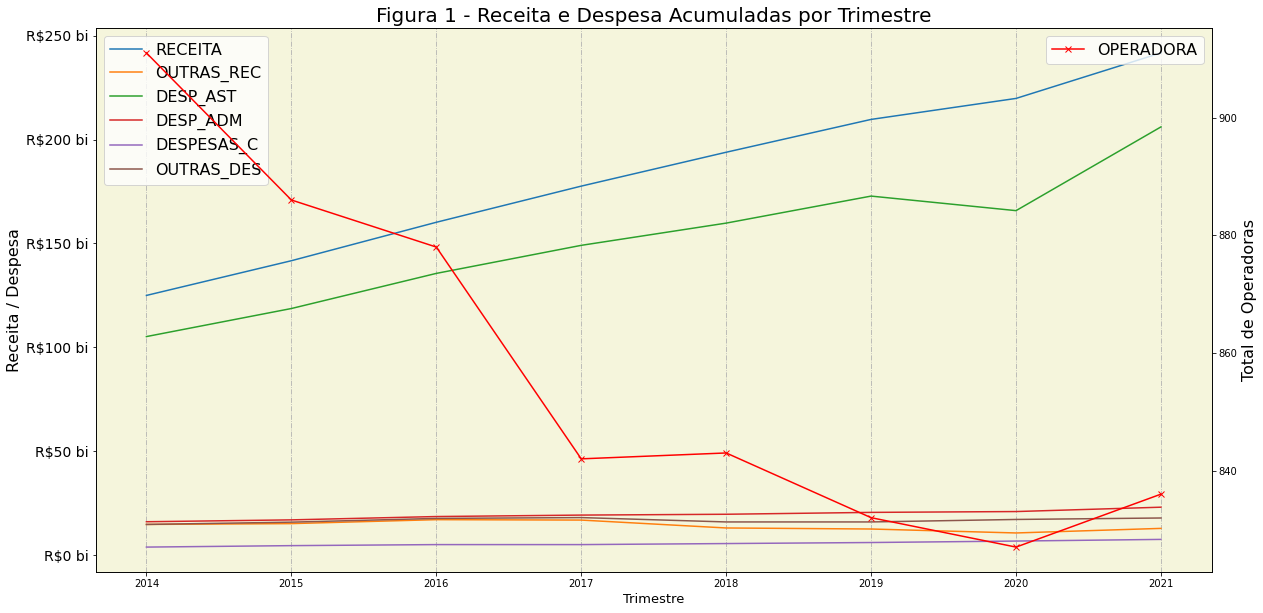

In [9]:
fig,ax1 = plt.subplots()

diops_analise.plot(y=['RECEITA','OUTRAS_REC','DESP_AST','DESP_ADM','DESPESAS_C','OUTRAS_DES'], figsize=(20,10), ax = ax1)
ax1.set_title('Figura 1 - Receita e Despesa Acumuladas por Trimestre',fontsize = 20)
ax1.set_xticks(diops_analise.index)
ax1.set_xticklabels(diops_analise.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')   

ax2 = ax1.twinx()

diops_analise.plot(y=['OPERADORA'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(diops_analise.index)
ax2.set_xticklabels(diops_analise.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.show()

In [10]:
diops_analise = diops_microdados.groupby(['ANO'], as_index=False).agg({ 'RECEITA':lambda x: sum_billion(x),
                                                                        'OUTRAS_REC':lambda x: sum_billion(x),
                                                                        'DESP_AST':lambda x: sum_billion(x),
                                                                        'DESP_ADM':lambda x: sum_billion(x),
                                                                        'DESPESAS_C':lambda x: sum_billion(x), 
                                                                        'OUTRAS_DES':lambda x: sum_billion(x),
                                                                        'OPERADORA':lambda x: x.nunique()})

diops_analise.set_index('ANO', inplace=True)

diops_analise

,RECEITA,OUTRAS_REC,DESP_AST,DESP_ADM,DESPESAS_C,OUTRAS_DES,OPERADORA
ANO,,,,,,,
2014,125.00,14.80,105.20,16.10,3.90,14.80,911
2015,141.70,15.20,118.70,17.00,4.60,15.90,886
2016,160.20,17.10,135.60,18.60,5.10,17.70,878
2017,177.60,16.90,149.10,19.30,5.10,18.10,842
2018,193.90,13.10,159.80,19.70,5.60,16.00,843
2019,209.70,12.60,172.80,20.60,6.10,16.00,832
2020,219.80,10.70,165.80,21.00,6.80,17.20,827
2021,241.70,12.90,206.10,23.10,7.60,17.90,836
